[-240 -120    0   60  240  360  480] [6045. 4884.    0. 1130.    0. 3710.    0.]


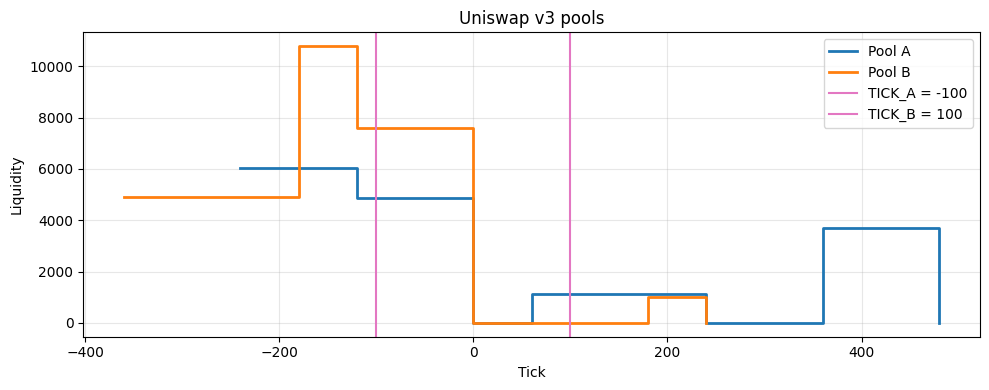

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# | Fee Tier | Typical Tick Spacing |
# | -------- | -------------------- |
# | 0.05%    | 1                    |
# | 0.3%     | 60                   |
# | 1%       | 200                  |
# | 10%      | 2000                 |

TICK_SPACING_A = 60
TICK_SPACING_B = 60

TICK_A = -100
TICK_B = 100

def random_positions(
    n_positions,
    tick_min=-500,
    tick_max=500,
    tick_spacing=10,
    min_width=20,
    max_width=200,
    min_liquidity=500,
    max_liquidity=6000,
):
    positions = []

    # snap tick_min and tick_max to tick spacing
    tick_min = (tick_min // tick_spacing) * tick_spacing
    tick_max = (tick_max // tick_spacing) * tick_spacing

    for _ in range(n_positions):
        # generate lower tick as multiple of tick_spacing
        lower = random.randint(tick_min // tick_spacing, (tick_max - min_width) // tick_spacing) * tick_spacing

        # random width in ticks, then snap upper
        width = random.randint(min_width, max_width)
        upper = lower + width
        # snap upper to tick spacing
        upper = ((upper + tick_spacing - 1) // tick_spacing) * tick_spacing
        if upper > tick_max:
            upper = tick_max

        liquidity = random.randint(min_liquidity, max_liquidity)
        positions.append((lower, upper, liquidity))

    return positions

def build_liq(positions):
    liquidity_net = defaultdict(float)

    for lower, upper, L in positions:
        liquidity_net[lower] += L
        liquidity_net[upper] -= L

    ticks = np.array(sorted(liquidity_net.keys()))
    delta = np.array([liquidity_net[t] for t in ticks])
    active = np.cumsum(delta)

    return ticks, active


pool_A_positions = random_positions(n_positions=4, tick_spacing=TICK_SPACING_A)
pool_B_positions = random_positions(n_positions=4, tick_spacing=TICK_SPACING_B)

ticks_A, liq_A = build_liq(pool_A_positions)
ticks_B, liq_B = build_liq(pool_B_positions)

print(ticks_A, liq_A)

plt.figure(figsize=(10, 4))

plt.step(
    ticks_A,
    liq_A,
    where="post",
    linewidth=2,
    label="Pool A"
)

plt.step(
    ticks_B,
    liq_B,
    where="post",
    linewidth=2,
    label="Pool B"
)

plt.axvline(TICK_A, linewidth=1.5, color="tab:pink", label=f"TICK_A = {TICK_A}")
plt.axvline(TICK_B, linewidth=1.5, color="tab:pink", label=f"TICK_B = {TICK_B}")

plt.xlabel("Tick")
plt.ylabel("Liquidity")
plt.title("Uniswap v3 pools")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import math

Q96 = 2**96

def tick_to_sqrt_price_x_96(tick):
    return int(1.0001 ** (tick / 2) * Q96)

def calc_x(liq, sqrt_p):
    return liq / sqrt_p

def calc_y(liq, sqrt_p):
    return liq * sqrt_p

def calc_dx(L, sqrt_p_lo, sqrt_p_hi):
    if sqrt_p_lo >= sqrt_p_hi:
        return 0
    return L * (1 / sqrt_p_lo - 1 / sqrt_p_hi)

def calc_dy(L, sqrt_p_lo, sqrt_p_hi):
    if sqrt_p_lo >= sqrt_p_hi:
        return 0
    return L * (sqrt_p_hi - sqrt_p_lo)

def calc_dx_to_sqrt_p_lo(L, sqrt_p_hi, dx):
    return 1 / (dx / L + 1 / sqrt_p_hi)

def calc_dy_to_dp():
    pass

# Optimal y amount in for pool A (dy_A -> pool A -> dx -> pool B -> dy_B) 
def calc_optimal_amt_in(X_A, Y_A, X_B, Y_B, f_A, f_B):
    k0 = X_A * Y_A * X_B * Y_B * (1 - f_A) * (1 - f_B)
    k1 = (X_B + X_A * (1 - f_B)) * (1 - f_A)
    a = k1 * k1
    b = 2 * k1 * X_B * Y_A
    c = (X_B * Y_A)**2 - k0
    return (-b + math.sqrt(b*b - 4*a*c)) / (2*a)


# dy_A -> dx -> dy_B
# TODO: opposite direction
def calc_dya(pool_a, pool_b, sa, sb, fa, fb):
    # sa_lo initialized to pool A's current sqrt price
    sa_lo = 0
    sa_hi = 0
    sb_lo = 0
    # sb_hi initialized to pool B's current sqrt price
    sb_hi = 0
    La = 0
    Lb = 0

    dya = 0
    # TODO:
    dyb = 0

    # TODO: assertions
    while sa_lo < sb_hi:
        if sa_hi <= sb_lo:
            xa = cal_dx(La, sa_lo, sa_hi)
            xb = cal_dx(Lb, sb_lo, sb_hi)
            if xa <= xb:
                # dya -> xa -> dyb
                sa_lo = sa_hi
                sa_hi = 0 # TODO: next tick from pool A
                # TODO: move sb_hi to next tick if sb_hi = sb_lo
                sb_lo = sb_lo
                # TODO: include input fee
                sb_hi = calc_dx_to_sqrt_p_lo(Lb, sb_hi, xa)
                dya += calc_dy(La, sa_lo, sa_hi) / (1 - fa)
            else:
                # dya -> xb -> dyb
                sa_lo = sa_lo
                sa_swap = calc_dx_to_sqrt_p_lo(La, sa_hi, xb)
                sb_lo = sb_lo
                # TODO: update
                sb_hi = 0
                # TODO: include input fee
                dya += calc_dy(La, sa_swap, sa_hi) / (1 - fa)
                sa_hi = sa_swap
        else
            # sb_lo < sa_hi
            # Find p*
            # if pb_lo <= p* <= pa_hi -> swap
            # if p* < pb_lo -> swap until pb_lo
            # if pa_hi < p* -> swap until pa_hi
            pass
            
        continue

    return (dya, dyb)

In [ ]:
# pa < pb
# dya -> dx -> dyb

def calc_dx(L, s_lo, s_hi):
    return 0

def calc_dy(L, s_lo, s_hi):
    return 0

def calc_s_lo_dx(L, s_hi, dx):
    return 0

def calc_s_hi_dx(L, s_lo, dx):
    return 0

def calc_s_hi_dy(L, s_lo, dy):
    return 0

def calc_s_lo_dy(L, s_hi, dy):
    return 0

def next(pool, i):
    return (0, 0, 0)

def calc_dya_opt():
    return (0, 0, 0)


# pool = [(lo, hi, liq)]
def calc_dya(pool_a, pool_b, fa, fb):
    (sa_lo, sa_hi, la) = pool_a[0]
    (sb_lo, sb_hi, lb) = pool_b[0]
    a = 0
    b = 0
    dya = 0
    dyb = 0
    while sa_lo < sb_hi:
        if sa_hi <= sb_lo:
            xa = calc_dx(la, sa_lo, sa_hi)
            xb = calc_dx(lb, sb_lo, sb_hi)
            if xa <= xb:
                dya += calc_dy(la, sa_lo, sa_hi) / (1 - fa)
                sb = calc_s_lo_dx(lb, sb_hi, xa * (1 - fb))
                dyb += calc_dy(la, sb, sb_hi)
                if sb == sb_lo:
                    (sb_lo, sb_hi, lb) = next(pool_b, b)
                    b += 1
                else:
                    sb_hi = sb
                (sa_lo, sa_hi, la) = next(pool_a, a)
                a += 1      
            else:
                dx = min(xa, xb / (1 - fb))
                sa = 0
                if dx == xa:
                    sa = sa_hi
                else:
                    sa = calc_s_hi_dx(la, s_lo, dx)
                dya += calc_dy(la, sa_lo, sa) / (1 - fa)
                sb = 0
                if dx < xa:
                    sb = sb_lo
                else:
                    sb = calc_s_lo_dx(lb, sb_hi, xa * (1 - fb))
                dyb += calc_dy(lb, sb, sb_hi)
                if sa == sa_hi:
                    (sa_lo, sa_hi, la) = next(pool_a, a)
                    a += 1
                else:
                    sa_lo = sa
                if sb == sb_lo:
                    (sb_lo, sb_hi, lb) = next(pool_b, b)
                    b += 1
                else:
                    sb_hi = sb
        else:
            (dya_opt, dyb_opt, s_opt) = calc_dya_opt()
            if sa_hi < s_opt:
                dya += calc_dy(la, sa_lo, sa_hi) / (1 - fa)
                xa = calc_dx(la, sa_lo, sa_hi)
                sb = calc_s_lo_dx(lb, s_hi, xa * (1 - fb))
                dyb += calc_dy(lb, sa, s_hi)
                (sa_lo, sa_hi, la) = next(pool_a, a)
                a += 1
                sb_hi = sb
            elif s_opt < sb_lo:
                xb = calc_dx(lb, sb_lo, sb_hi)
                xa = calc_dx(lb, sa_lo, sa_hi)
                dx = min(xa, xb / (1 - fb))
                sa = calc_s_hi_dx(la, s_lo, dx)
                dya += calc_dy(la, sa_lo, sa) / (1 - fa)
                sb = calc_s_lo_dx(lb, sb_hi, dx * (1 - fb))
                dyb += calc_dy(lb, sb, sb_hi)
                if dx == xa:
                    (sa_lo, sa_hi, la) = next(pool_a, a)
                    a += 1
                    sb_hi = sb
                else:
                    sa_lo = sa
                    (sb_lo, sb_hi, lb) = next(pool_b, b)
                    b += 1   
            else:
                dya += dya_opt
                dyb += dyb_opt
                sa_lo = s_opt
                sb_hi = s_opt
    return (dya, dyb)

calc_dya()